<a href="https://colab.research.google.com/github/snyderjo/MelnomaIdentification/blob/main/Kaggle_Melanoma_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import re

In [2]:
print(tf.__version__)

2.8.0


# Malignant Skin Lesion Identification
The purpose behind this is many-fold.
I am making use of the publicly-available data of [Kaggle's](https://www.kaggle.com/) [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/overview) competition.  

Portions of this were inspired by [this notebook](https://www.kaggle.com/code/tuckerarrants/melanoma-5fold-efficientnet-augmentation-s) on the melanoma classification competition and the [deep leaning Udemy course](https://github.com/mrdbourke/tensorflow-deep-learning) taught by Mark Bourne.

This is not intended as a submission to the competition.

Set global variables

In [3]:
BATCH_SIZE = 32

SEED = 12345

CLASSES = ['benign', 'malignant']

IMG_SIZE = [1024,1024]


## Enable the Kaggle authentication
Upload a json file containing one's kaggle crendials as described in the link below.  

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [4]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Competition Data

There's a whole lot of data available to download.  
We'll download the TFREC data for the sake of speed.

Uncomment and execute the line below to see the datasets available for download.

In [6]:
#! kaggle competitions files siim-isic-melanoma-classification

## Download the data
These are TFRecord files containing the skin lesion images and target classes.
Note that the number of records contained in a given .tfrec file is the number appearing after the dash in the 

TO-DO: make use of bash commands to eliminate all of the hard-coded filenames below.

In [7]:
#an unfortunate amount of hard-coded downloads
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train00-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train01-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train02-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train03-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train04-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train05-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train06-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train07-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train08-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train09-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train10-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train11-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train12-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train13-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train14-2071.tfrec 
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/train15-2061.tfrec 

!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test00-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test01-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test02-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test03-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test04-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test05-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test06-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test07-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test08-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test09-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test10-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test11-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test12-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test13-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test14-687.tfrec
!kaggle competitions download siim-isic-melanoma-classification -f tfrecords/test15-677.tfrec

100% 550M/553M [00:06<00:00, 114MB/s] 
100% 553M/553M [00:06<00:00, 91.8MB/s]
 99% 549M/555M [00:07<00:00, 81.0MB/s]
100% 555M/555M [00:08<00:00, 72.2MB/s]
 99% 550M/554M [00:02<00:00, 255MB/s]
100% 554M/554M [00:02<00:00, 215MB/s]
100% 555M/555M [00:09<00:00, 76.1MB/s]
100% 555M/555M [00:09<00:00, 59.1MB/s]
100% 558M/559M [00:08<00:00, 84.2MB/s]
100% 559M/559M [00:08<00:00, 70.4MB/s]
 98% 546M/557M [00:10<00:00, 89.9MB/s]
100% 557M/557M [00:10<00:00, 54.6MB/s]
 99% 552M/556M [00:07<00:00, 85.4MB/s]
100% 556M/556M [00:07<00:00, 80.6MB/s]
100% 563M/564M [00:08<00:00, 72.7MB/s]
100% 564M/564M [00:08<00:00, 69.9MB/s]
 97% 540M/555M [00:04<00:00, 225MB/s]
100% 555M/555M [00:04<00:00, 118MB/s]
 99% 555M/561M [00:10<00:00, 67.5MB/s]
100% 561M/561M [00:10<00:00, 54.0MB/s]
 98% 545M/558M [00:09<00:00, 75.0MB/s]
100% 558M/558M [00:09<00:00, 62.6MB/s]
 99% 553M/557M [00:03<00:00, 176MB/s]
100% 557M/557M [00:03<00:00, 155MB/s]
 99% 553M/556M [00:07<00:00, 95.4MB/s]
100% 556M/556M [00:07<00:00, 79

Unzip the downloaded TFRecord data sets and delete the zip version.

In [8]:
import zipfile
import glob

In [9]:
for zip_file_name in glob.glob("*.tfrec.zip"):
  #print(zip_file_name)
  zipref = zipfile.ZipFile(zip_file_name,"r")
  zipref.extractall()
  zipref.close()


! rm *.tfrec.zip

## Data Set-Up
The idea here is to pass these files to a set of functions capable of parsing the data therein such that one can visualize them and pass them on to whichever model or function.

In [10]:
tf.random.set_seed(SEED)

train_files = np.array(tf.io.gfile.glob("./train*.tfrec"))
test_files = np.array(tf.io.gfile.glob("./test*.tfrec"))


Establish some constants to use later

In [11]:
#copied from Tucker Arrant's notebook
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

TOTAL_NUM_TRAINING_IMAGES = count_data_items(train_files)
TOTAL_NUM_TEST_IMAGES = count_data_items(test_files)
print("There are at total of {} images in the training data sets, and {} images in the test data sets".format(TOTAL_NUM_TRAINING_IMAGES,TOTAL_NUM_TEST_IMAGES))

There are at total of 33126 images in the training data sets, and 10982 images in the test data sets


In [12]:
def read_train_example(example): 
  """
  Provide a function and dict of features to extract from these TFRecord files
  """
  tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64, default_value = 0),
        'target'                       : tf.io.FixedLenFeature([], tf.int64, default_value = 0)
        }       
  example = tf.io.parse_single_example(example,tfrec_format)
  return example["image"], example["target"]

def read_unlabeled_tfrecord(example, return_image_name = True):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def read_unlabeled_test_img(example):
  tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
  example = tf.io.parse_single_example(example, tfrec_format)
  return example['image']



In [13]:
def get_dataset(files, shuffle = True, labeled = True, return_image_name = False, batch_size = BATCH_SIZE):
  """
  returns an iterateable dataset of decoded images and (image-name or target)
  """
  AUTO = tf.data.AUTOTUNE

  dataset = tf.data.TFRecordDataset(files)
  
  dataset = dataset.cache()

  if shuffle:
    dataset = dataset.shuffle(2048, reshuffle_each_iteration = True)
    options = tf.data.Options()
    options.deterministic = False
    dataset = dataset.with_options(options)

  if labeled:
    dataset = dataset.map(read_train_example, num_parallel_calls=AUTO)
  else :
    dataset = dataset.map(lambda example: read_unlabeled_tfrecord(example, return_image_name), num_parallel_calls=AUTO)

  dataset = dataset.map(lambda img, target_or_name: (tf.io.decode_image(img,channels = 3), target_or_name), num_parallel_calls=AUTO)

  #dataset = dataset.batch(batch_size)

  #dataset = dataset.prefetch(AUTO)

  return dataset


## Visualization
Create a set of functions to visualize the input images.

In [14]:
test_ds = get_dataset(train_files)

In [15]:
from matplotlib import pyplot as plt

def numpy_iterator(dataset):
  """
  return a numpy iterator of the tf.Data
  """
  return dataset.as_numpy_iterator()

def plot_labeled_imgs(dataIterator, dim = [4,4], classes = CLASSES):
  
  plt.figure(figsize=[13.0,13.0])

  i = 1

  while i <= dim[0] * dim[1]:
    img, lab = next(dataIterator)
    plt.subplot(dim[0],dim[1],i)
    plt.imshow(img)
    plt.axis(False);
    plt.title(classes[lab])
    i += 1

  plt.tight_layout()

  plt.show()

def plot_unlabeled_imgs(dataIterator, dim = [4,4]):
  plt.figure(figsize=[13.0,13.0])

  i = 1

  while i <= dim[0] * dim[1]:
    img, lab = next(dataIterator)
    plt.subplot(dim[0],dim[1],i)
    plt.imshow(img)
    plt.axis(False);
    plt.title('')
    i += 1

  plt.tight_layout()

  plt.show()




In [16]:
#create an source data set for visualization
train_ds = get_dataset(train_files)
graph_train_iter = numpy_iterator(train_ds)


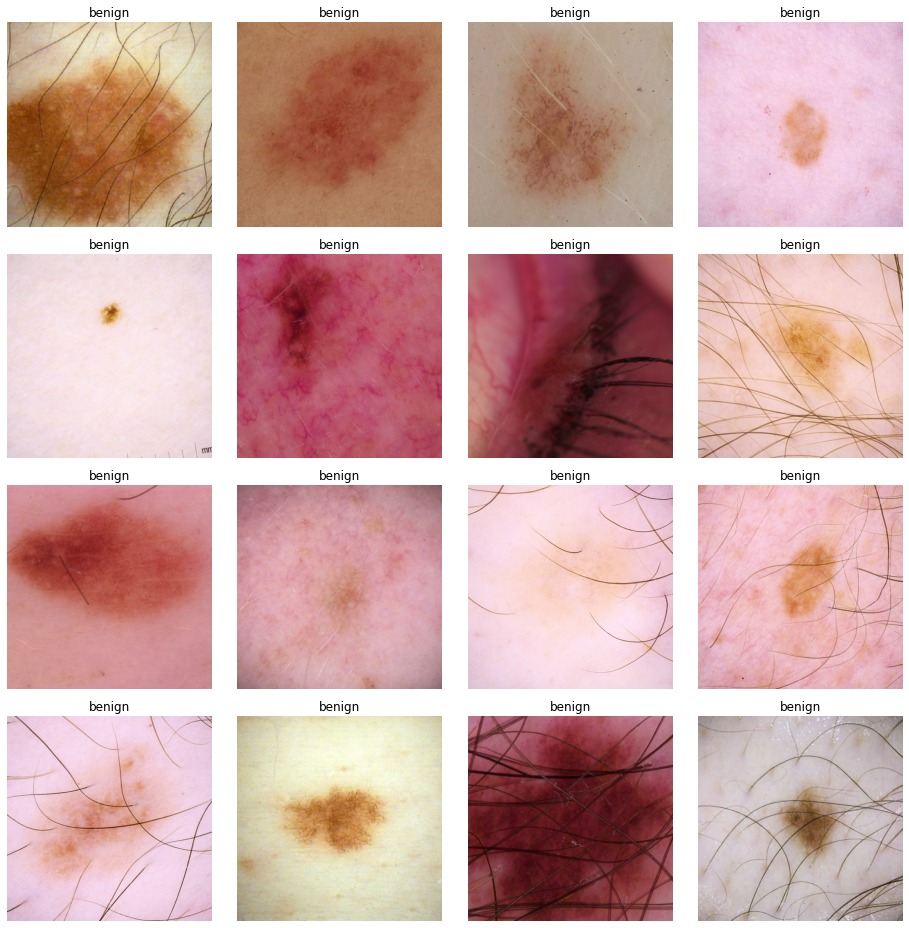

In [17]:
#this can command can be run multiple times to display different images and labels
plot_labeled_imgs(graph_train_iter)

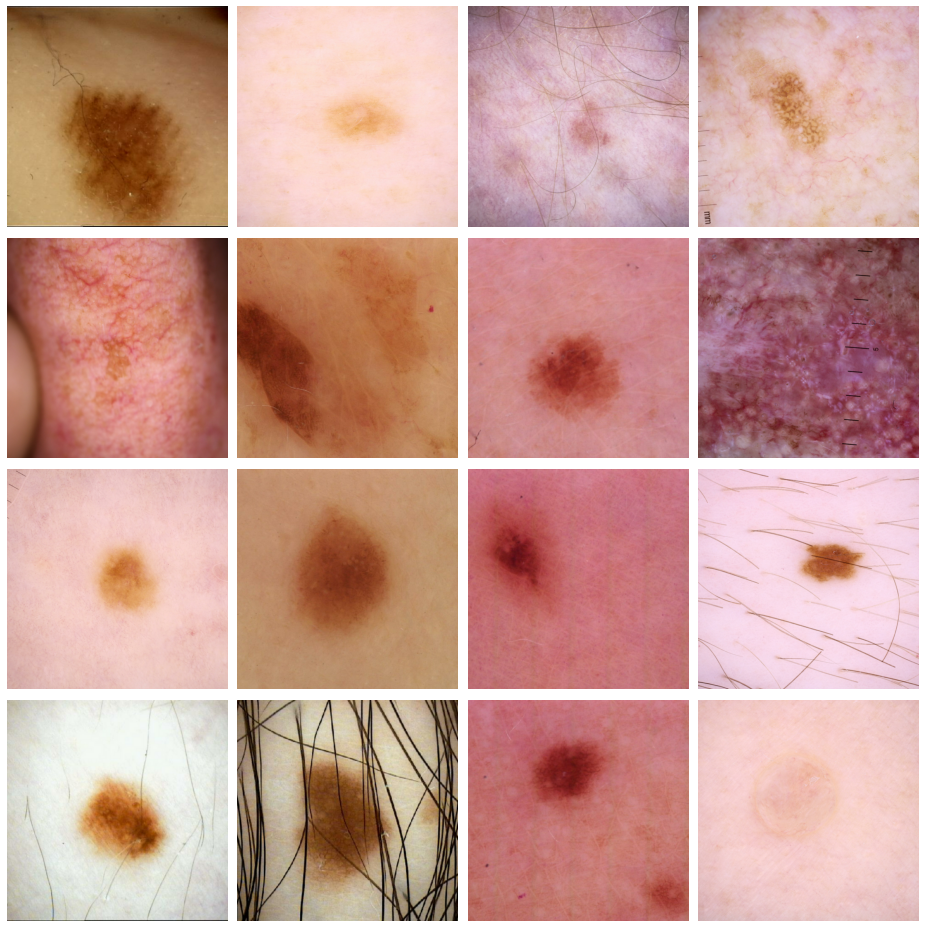

In [18]:
##one could create a iterator for test dataset as well
plot_unlabeled_imgs(graph_train_iter)

## Data Augmentation
We want to augment the data as it trains, i.e. make changes to the images such that it creates a multitude of "artificial" observations.  

We will accomplish this using a sequential layer of random transformations.

In [19]:
from tensorflow.keras import layers

#create a data augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.Resizing(224,224) #this is the size of the input for efficientNetB0                               
  , layers.RandomContrast(0.3)
  , layers.RandomFlip()
  , layers.RandomRotation(0.7)
  , layers.RandomZoom(0.3)
  , layers.RandomHeight(0.2)
  , layers.RandomWidth(0.2)
  #,layers.Rescale(1/255.) #unnecessary fo efficientNet
], name = "data_augmentation")

In [20]:
## How does this affect our images?
import matplotlib.image as mpimg

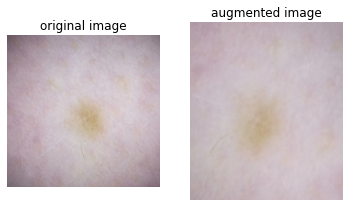

In [21]:
# This cell can be run multiple times to examine different images
img, _ = graph_train_iter.next()
plt.subplot(1,2,1)
plt.imshow(img/255.)
plt.title("original image")
plt.axis(False)

plt.subplot(1,2,2)
img2 = data_augmentation(tf.expand_dims(img,axis=0))
plt.imshow(tf.cast(tf.squeeze(img2),dtype=tf.int32))
plt.title("augmented image")
plt.axis(False)

plt.show;
# One of the augentations appears to casue a clipping warning--TO-DO

### Potential Augmentation To-Do's:
* Consider adding Coarse Dropout or Gridmask.
* Consider adding random brightness from tf.keras.preprocessing.image

# Modeling
Given the relatively small dataset (from a CNN perspective), it's best to make use of transfer learning

## Training Data Split
Split the training data into an approxemate 20% validation, and 80% training data.

I have yet to find a means of randomly selecting data within a given tfrecords file.  Instead, we will randomly select a portion of the 15 training TFrecord files, and treat those as the source of validation data.

In [22]:
from sklearn.model_selection import train_test_split

PERCENT_SPLIT = 3/16.

num_train_files = len(tf.io.gfile.glob("./train*.tfrec"))

training_indices, validation_indices = train_test_split(np.arange(num_train_files),test_size = PERCENT_SPLIT, random_state = SEED)

#"training_files" below to distinguish it from train_files several cells above
training_files = tf.io.gfile.glob(["./train%.2i*.tfrec"%x for x in training_indices])
val_files = tf.io.gfile.glob(["./train%.2i*.tfrec"%x for x in validation_indices])

NUM_TRAINING_IMAGES = count_data_items(training_files)
NUM_VALIDATION_IMAGES = count_data_items(val_files)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
STEPS_PER_EPOCH_VAL = NUM_VALIDATION_IMAGES // BATCH_SIZE

# I wish I knew why the .batch and .prefetch methods were necessary below.  It seems the same calls in get_dataset are not working.
training_dataset = get_dataset(training_files,shuffle = True, labeled = True, return_image_name = False, batch_size = BATCH_SIZE)
#training_dataset = training_dataset.cache()
training_dataset = training_dataset.repeat()
training_dataset = training_dataset.shuffle(2048)
training_dataset = training_dataset.batch(BATCH_SIZE)
training_dataset = training_dataset.prefetch(tf.data.AUTOTUNE)

validation_dataset = get_dataset(val_files,shuffle = True, labeled = True, return_image_name = False, batch_size = BATCH_SIZE)
#validation_dataset = validation_dataset.shuffle(NUM_TRAINING_IMAGES) #cause of *some* memory leakage
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

In [23]:

print("We have split {} total training images into {} images to pass to any model for training and {} validation images".format(TOTAL_NUM_TRAINING_IMAGES,NUM_TRAINING_IMAGES,NUM_VALIDATION_IMAGES))

We have split 33126 total training images into 26913 images to pass to any model for training and 6213 validation images


#### Callbacks
Create callbacks for:
* leaning rate
* model checkpoints

In [24]:
#model checkpoints
! mkdir model_checkpoints

mkdir: cannot create directory ‘model_checkpoints’: File exists


In [25]:
sv = tf.keras.callbacks.ModelCheckpoint("model_checkpoints"
                                        , monitor="val_loss"
                                        ,mode = "min"
                                        ,save_best_only = True
                                        ,save_weights_only = True
                                        ,save_freq = "epoch"
                                        )

Text(0.5, 1.0, 'Learning Rate Schedule')

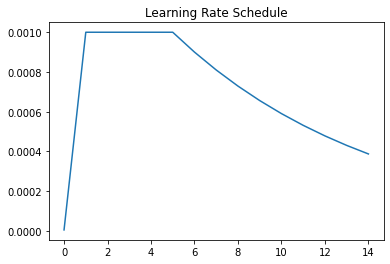

In [26]:
#learning rate
init_lr = 5e-6 #initial small learning rate to leave some error, i.e. allow the model to demonstrate improvement
post_lr =  .001 #
num_init_to_decay = 5
epochs = 15
decay_rate = .9 

def lr_rate(epoch):
  if epoch < 1:
    lr = init_lr
  elif epoch < num_init_to_decay:
    lr = post_lr
  else:
    lr = post_lr * decay_rate**(epoch - num_init_to_decay)
  return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_rate,verbose = True)

rng = [i for i in range(epochs)]
y = [lr_rate(x) for x in rng]
plt.plot(rng, y)
plt.title("Learning Rate Schedule")

In [27]:
#download the smallest EfficientNet, and freeze training.
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


In [28]:
input_shape = tuple(IMG_SIZE + [3,])

inputs = layers.Input(shape = input_shape, name="input")
x = data_augmentation(inputs)
x = base_model(x,training=False)# training = False so that batchnorm layers are not updated
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
x = layers.Dropout(0)(x)
outputs = layers.Dense(1,activation = "sigmoid",name = "outputs")(x)

model = tf.keras.Model(inputs,outputs)

#compile the model
model.compile(loss = "binary_crossentropy"
              , optimizer = tf.keras.optimizers.Adam(learning_rate=.001) 
              , metrics = ["AUC","accuracy"])

In [29]:
#examine the model 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 1024, 3)]   0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 1)                 1281  

In [30]:
# check to make sure we using a GPU
! nvidia-smi

Fri Apr 29 00:38:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    34W / 250W |    413MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
#previous runs have been crashing on the validation step => reduce the number of validation images considered
#preliminary googling indicates this is due to a memory leak in the validation step
history = model.fit(training_dataset
          , epochs = 5
          , validation_data = validation_dataset
          , steps_per_epoch = STEPS_PER_EPOCH
          , validation_steps = int(STEPS_PER_EPOCH_VAL *.15)
          , callbacks = [sv, lr_scheduler]
          )


Epoch 1: LearningRateScheduler setting learning rate to 5e-06.
Epoch 1/5
841/841 [==============================] - 141s 143ms/step - loss: 0.3559 - auc: 0.5473 - accuracy: 0.9661 - val_loss: 0.2583 - val_auc: 0.5354 - val_accuracy: 0.9774 - lr: 5.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
841/841 [==============================] - 105s 125ms/step - loss: 0.0833 - auc: 0.7078 - accuracy: 0.9828 - val_loss: 0.0902 - val_auc: 0.7513 - val_accuracy: 0.9806 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/5
841/841 [==============================] - 104s 124ms/step - loss: 0.0766 - auc: 0.7839 - accuracy: 0.9829 - val_loss: 0.0696 - val_auc: 0.7084 - val_accuracy: 0.9860 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/5
841/841 [==============================] - 102s 121ms/step - loss: 0.0761 - auc: 0.8086 - accuracy: 0.9825 - val_loss: 0.0917 - val_auc: 0.7659 - val_accuracy: 

### Plot the model metrics

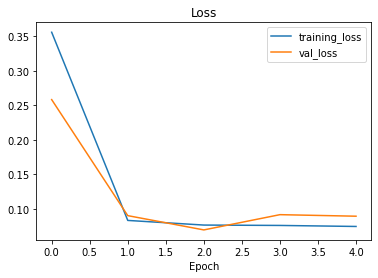

In [32]:
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, label = "training_loss")
plt.plot(epochs, val_loss, label = "val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend();

Note: given how imbalanced this data set is, accuracy is likely to be a poor evaluation metric.

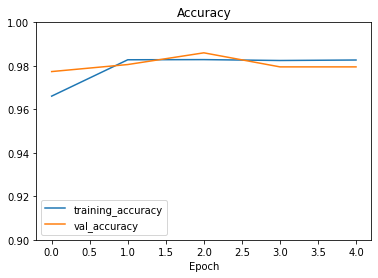

In [33]:
# Loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(loss))

plt.plot(epochs, accuracy, label = "training_accuracy")
plt.plot(epochs, val_accuracy, label = "val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim((.9,1))
plt.legend()

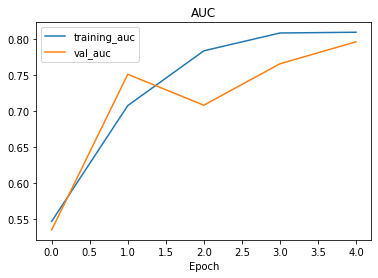

In [34]:
# AUC
auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(len(loss))

plt.plot(epochs, auc, label = "training_auc")
plt.plot(epochs, val_auc, label = "val_auc")
plt.title("AUC")
plt.xlabel("Epoch")
plt.legend();

## Fine Tuning
The idea now is to release the frozen layers in the base model to enable fine tuing.   We will release the last quarter of the layers in the EfficientNet

In [35]:
num_base_model_layers = len(base_model.layers)


In [36]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

#re-freeze the model layers prior to the last quarter
for layer in base_model.layers[:-int(.15 * num_base_model_layers)]:
  layer.trainable = False

#recompile the model
model.compile(loss = "binary_crossentropy"
              , optimizer = tf.keras.optimizers.Adam() 
              , metrics = ["AUC","accuracy"])


In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 1024, 3)]   0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 outputs (Dense)             (None, 1)                 1281  

Yup!  We have many more trainable parameters!

In [38]:
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 dropout True
5 outputs True


In [39]:
FINE_TUNE_EPOCHS = 10
history_fine_tune = model.fit(training_dataset
                              , epochs = FINE_TUNE_EPOCHS
                              , validation_data = validation_dataset
                              , steps_per_epoch = STEPS_PER_EPOCH
                              , validation_steps = int(STEPS_PER_EPOCH_VAL *.15)
                              , callbacks = [sv, lr_scheduler]
                              , initial_epoch = history.epoch[-1]
                              )


Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
841/841 [==============================] - 117s 125ms/step - loss: 0.0848 - auc: 0.7238 - accuracy: 0.9828 - val_loss: 0.0596 - val_auc: 0.7477 - val_accuracy: 0.9881 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/10
841/841 [==============================] - 103s 122ms/step - loss: 0.0817 - auc: 0.7653 - accuracy: 0.9819 - val_loss: 0.0703 - val_auc: 0.7859 - val_accuracy: 0.9849 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 7/10
841/841 [==============================] - 103s 122ms/step - loss: 0.0757 - auc: 0.7965 - accuracy: 0.9829 - val_loss: 0.0570 - val_auc: 0.8114 - val_accuracy: 0.9892 - lr: 9.0000e-04

Epoch 8: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 8/10
841/841 [==============================] - 103s 123ms/step - loss: 0.0749 - auc: 0.8307 - accuracy: 0.9827 - val_loss: 0.094

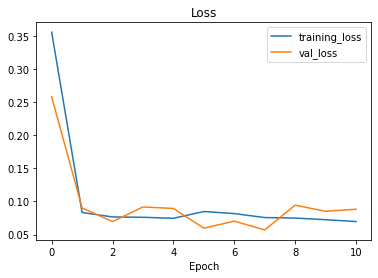

In [40]:
total_loss = history.history['loss'] + history_fine_tune.history['loss']
total_val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

epochs = range(len(total_loss))

plt.plot(epochs, total_loss, label = "training_loss")
plt.plot(epochs, total_val_loss, label = "val_loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend();

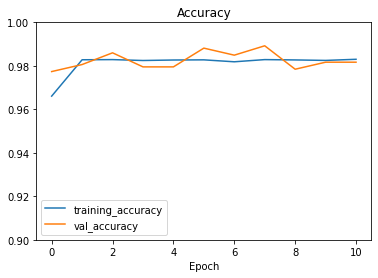

In [41]:

total_accuracy = history.history['accuracy'] + history_fine_tune.history['accuracy']
total_val_accuracy = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']

epochs = range(len(total_accuracy))

plt.plot(epochs, total_accuracy, label = "training_accuracy")
plt.plot(epochs, total_val_accuracy, label = "val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylim((.9,1))
plt.legend()

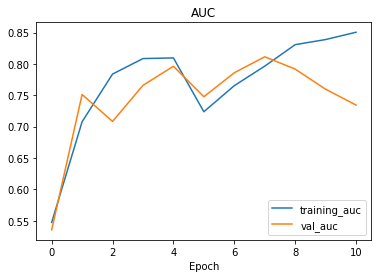

In [42]:
total_auc = history.history['auc'] + history_fine_tune.history['auc']
total_val_auc = history.history['val_auc'] +  history_fine_tune.history['val_auc']

epochs = range(len(total_auc))

plt.plot(epochs, total_auc, label = "training_auc")
plt.plot(epochs, total_val_auc, label = "val_auc")
plt.title("AUC")
plt.xlabel("Epoch")
plt.legend();

There's some distinct evidence of overfitting--Specifically, the clear divergence of AUC between training and validation data sets, loss to a lesser extent.

The is behavior is only so surprising given imbalance nature of the data.  That is to say, the model can substantially reduce loss simply by guessing benign for every prediction, which is the case for over 97% of the training data.

In [43]:
validation_results = model.evaluate(validation_dataset)

195/195 [==============================] - 21s 107ms/step - loss: 0.0828 - auc: 0.8113 - accuracy: 0.9812


## Model evaluation
We'll finally evaluate on the test data set.

In [44]:
test_dataset = tf.data.TFRecordDataset(test_files)
  
test_dataset = test_dataset.cache()

test_dataset = test_dataset

test_dataset = test_dataset.map(read_unlabeled_test_img, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.map(lambda img: (tf.io.decode_image(img,channels = 3)), num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)

In [45]:
#test_dataset = get_dataset(test_files, labeled=False,return_image_name = False)
preds = model.predict(test_dataset)

In [46]:
print(preds.shape)

(10982, 1)


In [47]:
#also grab the test data's labels
ds = get_dataset(test_files,labeled=False,return_image_name = True,shuffle = False)

test_data_names = np.array([img_name for img, img_name in ds.as_numpy_iterator()])


In [48]:
import pandas as pd
submission = pd.DataFrame(dict(img_name = test_data_names, target = preds[:,0]))

In [49]:
submission.head(10)

,img_name,target
0,b'ISIC_5583376',0.017236
1,b'ISIC_3813860',0.005261
2,b'ISIC_5668654',0.011584
3,b'ISIC_2061556',0.011959
4,b'ISIC_5537005',0.005650
5,b'ISIC_4078184',0.009684
6,b'ISIC_9816232',0.050798
7,b'ISIC_8926785',0.012376
8,b'ISIC_0452297',0.001041
9,b'ISIC_0556568',0.000563


In [50]:
#sanity check
print(f"Predicted {len(submission[submission['target'] > .5])} images out of a possible {submission.shape[0]} with melanoma")

Predicted 1 images out of a possible 10982 with melanoma


That's slightly reassuring.  One would hope there would be several prediction probabilities greater than 50%.
A lack is quite possibly a product of the imbalanced quality of the data.

### Important Question
Can the model generalize outside of the data set?
Let's give it a shot.

I've taken a photo of a mole on my forearm, and loaded it into my google drive.

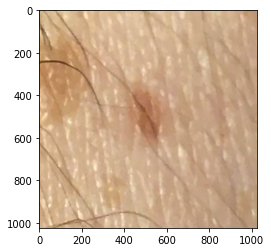

In [51]:
img = tf.io.read_file("./drive/MyDrive/mole.png")

img = tf.io.decode_png(img)

img = tf.image.resize(img, IMG_SIZE)

if img.shape[2] > 3:
  img = img[:, :, :3]

plt.imshow(img/255.)

img = tf.expand_dims(img,axis = 0)

In [52]:
model.predict(img)

array([[0.0032246]], dtype=float32)

Cool!  
It's unlikely to be melanoma!

# Conclusions
There's potential value in Convolutional Neural Networks in aiding those unfamiliar with malignant skin lesions.

### Remainding Questions
* Is a threshold 0.5 sufficient for clinical purposes?  
  + Probably not.  Given how imbalanced the data set is, any threshold needs thorough examination.
* Could this Convolutional convolutional neural net aid clinicians unfamiliar with the signs of melanoma?
  + Quite possibly.
* Does a probablility greater than .05 constitute an official diagnosis?
  + ***Absolutely not.***  Such a diagnosis can only be made by made by an approriately trained physician. 
* Does a probability of less than .05 mean a given skin lesion is not malignant?
  + *Nope.*  The answer immediately above applies here, as well.
* Is this model helpful?
  + The saying "all models are wrong, but some are useful" comes to mind.

  ### Possible extentions 